# Using Machine Learning to Predict Fitbit Sleep Scores

In this project I'm going to apply various Machine Learning models to predict Fitbit Sleep Scores based on a sample of almost one year of sleep score data. I will compare the accuracies of teh different models and look into the feature importances in each of the models.

## Import the relevant libraries and data

In [165]:
# Import all relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
# Import the data
sleep_data = pd.read_csv('combined.csv')

## Isolate the Fitbit App data

In [4]:
sleep_data.head()

,Unnamed: 0,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,0,2020-07-02,456,42,37,498,94,271,91,86.0,21.0,22.0,43.0,90.0,59.0,0.059426
1,1,2020-07-01,412,88,32,500,79,208,125,77.0,21.0,21.0,35.0,125.0,61.0,0.091463
2,2,2020-06-30,412,61,26,473,91,242,79,78.0,20.0,22.0,36.0,79.0,60.0,0.058201
3,3,2020-06-29,342,59,26,401,71,196,75,76.0,20.0,22.0,34.0,75.0,61.0,0.067885
4,4,2020-06-28,530,108,39,638,98,305,127,82.0,20.0,20.0,42.0,126.0,62.0,0.097103


In [5]:
# Obtain the data available through the app
app_data = sleep_data[sleep_data.columns[2:10]]

In [6]:
app_data.head()

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score
0,456,42,37,498,94,271,91,86.0
1,412,88,32,500,79,208,125,77.0
2,412,61,26,473,91,242,79,78.0
3,342,59,26,401,71,196,75,76.0
4,530,108,39,638,98,305,127,82.0


In [7]:
# Obtain the subset of independent variables used for MLR previously
app_reduced = app_data.drop(columns=['Minutes Asleep', 'Number of Awakenings', 'Minutes Light Sleep'])

In [8]:
app_reduced.head()

,Minutes Awake,Time in Bed,Minutes REM Sleep,Minutes Deep Sleep,overall_score
0,42,498,94,91,86.0
1,88,500,79,125,77.0
2,61,473,91,79,78.0
3,59,401,71,75,76.0
4,108,638,98,127,82.0


## Visualise the relationships between features and sleep score

Before moving on to the analysis and building of Machine Learning models I want to have a look at the relationship that each individual feature has with the overall sleep score to get a sense of their impact on it.

In [141]:
# Define a function to plot the scatterplots of the relationships between all independent variables and the dependent
# variable
def plot_relationships(df, num_cols):
    variables = df.columns
    # This function assumes that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,60))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

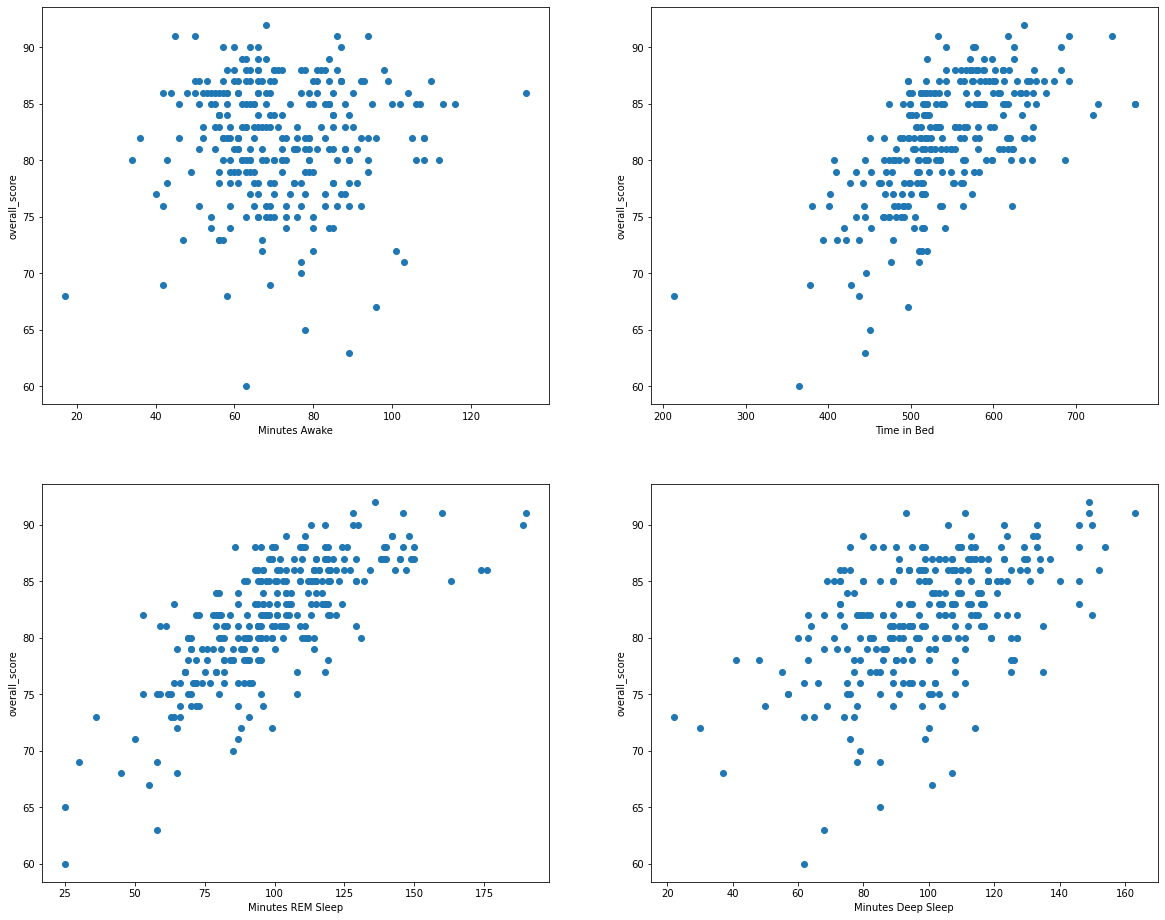

In [142]:
# Call the function with the reduced app data DataFrame and subplots in a grid of two columns
plot_relationships(app_reduced, 2)

Taken by themselves, Time in Bed and Minutes REM Sleep seem to have the strongest positive relationships with the overall sleep score. Generally speaking this makes sense because more time in bed should lead to more sleep, and therefore more quality sleep, and REM sleep has been found to be extremely important for many restorative functions and memory formation. (Elaborate more!)

In [143]:
# Inspect the correlations
app_reduced.corr()

,Minutes Awake,Time in Bed,Minutes REM Sleep,Minutes Deep Sleep,overall_score
Minutes Awake,1.000000,0.652037,0.160597,0.303564,0.033523
Time in Bed,0.652037,1.000000,0.583927,0.513741,0.616046
Minutes REM Sleep,0.160597,0.583927,1.000000,0.433558,0.745308
Minutes Deep Sleep,0.303564,0.513741,0.433558,1.000000,0.503672
overall_score,0.033523,0.616046,0.745308,0.503672,1.000000


## Split the data into training, validation and test set

Most data science projects that can be found online provide a training set and a test set that are well separated and that leave out the variable to be predicted in the test set, so as to assure no spillover effects. The training set can then be split into training and validation set without worrying about the test set because that has been neatly separated out already. Because I am solely relying on the data I was able to obtain from Fitbit, I have to split the data into training, validation and test set myself. There are many ways to do this but the most straight forward is to use the train_test_split twice.

Furthermore, when building Machine Learning models it is crictical to make sure that information about test (and validation) data does not spill over into the the training stage of model building. Because the scaling of features always involves some information about the data that is used for the scaling (i.e. mean, variance, maximum or minimum values) we have to make sure that the test and validation set are separated from the training set before we scale the data. Therefore, before I proceed I split the data into training, validation and test set. 

In [161]:
# Perform first split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(app_reduced[app_reduced.columns[:-1]], app_reduced['overall_score'],
                                                   test_size=0.2, random_state=420)

In [127]:
# Perform the second split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=420)

In [129]:
# Check the lengths of the different subsets
len(X_train), len(X_valid), len(X_test)

(171, 57, 58)

Now that we have a training set, validation set and test set we can proceed as follows: Train models on the training data, measure their accuracy on the validation data, tweak the model to be more accurate and measure the new accuracy, once we're happy with its performance we measure its generalisability on the test data.

## Scaling the features

Although for the Machine Learning Models in this project feature scaling is not required, it is considered best practice to scale features when comparing different models and their performance.

In [144]:
# Create the scaler with object range of 0-1
scaler = MinMaxScaler()

# Fit and transform using the training data
scaler.fit_transform(X_train)

# Transform the validation and test features
scaler.transform(X_valid)
scaler.transform(X_test)

array([[0.28125   , 0.54659498, 0.53939394, 0.53900709],
       [0.54166667, 0.47849462, 0.40606061, 0.53900709],
       [0.48958333, 0.63799283, 0.53939394, 0.68085106],
       [0.53125   , 0.68996416, 0.70909091, 0.64539007],
       [0.375     , 0.57526882, 0.68484848, 0.75886525],
       [0.71875   , 0.84767025, 0.51515152, 0.68794326],
       [0.40625   , 0.35483871, 0.23636364, 0.39007092],
       [0.625     , 0.71505376, 0.6969697 , 0.53900709],
       [0.4375    , 0.44623656, 0.28484848, 0.73049645],
       [0.45833333, 0.58243728, 0.27272727, 0.45390071],
       [0.5       , 0.5125448 , 0.54545455, 0.68085106],
       [0.55208333, 0.69713262, 0.51515152, 0.64539007],
       [0.63541667, 0.4265233 , 0.        , 0.44680851],
       [0.625     , 0.70430108, 0.57575758, 0.5106383 ],
       [0.38541667, 0.5125448 , 0.56969697, 0.41134752],
       [0.58333333, 0.52150538, 0.43030303, 0.53900709],
       [1.03125   , 1.        , 0.64848485, 0.77304965],
       [0.40625   , 0.32437276,

## Defining performance measures

The performance measures I want to use to compare the different ML models are Accuracy and Score. Average Error is added to the list as an extra.

In [56]:
def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

## Multiple Linear Regression

The first model I would like to use is MLR. I used MLR in another project to understand the relationship between the independent variables and the sleep score. This time, I will use it to make predictions about sleep scores and test the accuracy of this linear model.

In [145]:
# Create regressor
regressor = LinearRegression()

# Fit MLR model to training data
mlr = regressor.fit(X_train, y_train)

In [146]:
# Evaluate the performance
scoring(mlr, X_valid, y_valid)

Model Performance
Mean Absolute Error: 2.1015.
Mean Squared Error: 7.3154.
R^2 Score = 0.6256.
Accuracy = 97.44%.


Let's have a look at the feature importances in the Regression. To compute them I will use the relative weight of the coefficients.

In [147]:
# Get coefficients
coef = mlr.coef_

In [148]:
# Create a DataFrame with the coefficients and feature importances of all independent variables
mlr_feats = pd.DataFrame()

# Create coeffciient column
mlr_feats['Coefficient'] = coef

# Set the index to teh corresponding independent variables
mlr_feats.index = X_train.columns

# Compute relative feature importances
mlr_feats['Relative Feature Importance'] = mlr_feats.apply(lambda x: abs(x)/mlr_feats.Coefficient.abs().sum())
mlr_feats

,Coefficient,Relative Feature Importance
Minutes Awake,-0.189898,0.558859
Time in Bed,0.059069,0.173835
Minutes REM Sleep,0.065218,0.191933
Minutes Deep Sleep,0.025611,0.075373


The coefficients in our model are close to those of the MLR using the entire dataset. Looking at the feature importances in combination with the sign of the coefficients provides an important insight (ignoring multicollinearity!). Minutes Awake seem to have the biggest impact on sleep score and because that variable has a negative coefficient, it's impact is a sleep score reducing one. Disregarding multicollinearity, these feature importances indicate that it takes more than two minutes of REM sleep to make up for one minute of being awake. Furthermore, REM sleep appears to be almost twice as important as deep sleep when it comes to their impact on sleep score.

## K-Nearest Neighbors

In [149]:
# Create regressor
knn_regressor = KNeighborsRegressor()

# Fit MLR model to training data
knn = knn_regressor.fit(X_train, y_train)

In [150]:
# Evaluate the performance
scoring(knn, X_valid, y_valid)

Model Performance
Mean Absolute Error: 2.0912.
Mean Squared Error: 6.9698.
R^2 Score = 0.6433.
Accuracy = 97.44%.


## Random Forest

In [151]:
# Create regressor
rf_regressor = RandomForestRegressor(n_estimators=500, random_state=420)

# Fit RF model to training data
rf = rf_regressor.fit(X_train, y_train)

In [152]:
# Evaluate the performance
scoring(rf, X_valid, y_valid)

Model Performance
Mean Absolute Error: 1.9165.
Mean Squared Error: 6.2314.
R^2 Score = 0.6811.
Accuracy = 97.67%.


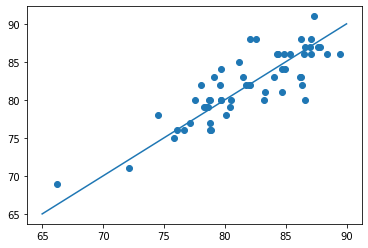

In [153]:
# Make predictions
y_pred = rf.predict(X_valid)

x = np.linspace(65, 90, 25)
y = x

plt.scatter(y_pred, y_valid)
plt.plot(x, y)

In [154]:
# Create a DataFrame of the feature importances 
rf_feats = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['Feature Importance'])
rf_feats

,Feature Importance
Minutes Awake,0.106339
Time in Bed,0.218054
Minutes REM Sleep,0.582607
Minutes Deep Sleep,0.093000


In case of a random forest regression, feature importance represents a measure of how much a feature decreases impurity in the set decision trees. Remember that at every node in a tree the data has to be split so that similar value sof dependent variables end up in the same set after the split, thereby decreasing the impurity. For classification problems, the measure of impurity is called Gini Impurity, which is absed on information gain, and for regression problems the measure of impurity is variance. In a random forest regression, therefore, a more important feature is one that leads to a split in the dataset that leads to a strong decrease in variance.

Minutes REM sleep appears to be the feature that decreases impurity the most, followed by Time in Bed and then Minutes Awake and Minutes Deep Sleep. 

In this model, we have to be careful and not attach too much value to the feature importances of the model. The reason is that the features are correlated and therefore once one of the features is used as a predictor the importance of the others will automatically be reduced since a lot of the impurity that they could have removed is already removed by the feature that was considered before them and is highly correlated to them.

Next, let's look at Extreme Gradient Boosting.

## Extreme Gradient Boosting 

In [155]:
# Create regressor
xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# Fit model to training data
xgb = xgb_regressor.fit(X_train, y_train)

In [156]:
# Evaluate the performance
scoring(xgb, X_valid, y_valid)

Model Performance
Mean Absolute Error: 2.2075.
Mean Squared Error: 8.4496.
R^2 Score = 0.5676.
Accuracy = 97.27%.


In [157]:
# Create a DataFrame to inspect the feature importances again
xgb_feats = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['Feature Importance'])
xgb_feats

,Feature Importance
Minutes Awake,0.190686
Time in Bed,0.280228
Minutes REM Sleep,0.407368
Minutes Deep Sleep,0.121719


Interestingly, Minutes REM Sleep is by far the most important feature again and, similar to the Random Forest, Time in Bed is the second most important.

## Introducing Cross-Validation

Because I am using a relatively small dataset of sleep scores and related features, a simple train test split may lead to over- or underfitting, meaning that the model may be either fitted too well to the training data or not well enough. One solution to this potential problem is to use Cross Validation. The general concept of Cross Validation is similar to that of splitting the data into training and testing data and can be thought of as a repeated train test split with subsequent testing of the model accuracy. In a train test split you train the model on one subset of the data and test it on the remaining data but you do that only once. In Cross Validation you perform multiple train test splits and for each split the test and training data are different. Basically, you split the data into a number of subsets, called folds, hold out one set at a time, train the model on the remaining data and test it on the hold out set. You repeat these steps until you have used every subset as the test set, i.e. by definition the number of times you perform these steps is equal to the number of folds you split the dataset into.

In [158]:
# Redefine the models to be tested
mlr_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators=500, random_state=420)
xgb_reg = xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.05)

In [159]:
# Put the models in a list to be used for cross validation
models = [mlr_reg, rf_reg, xgb_reg]

In [167]:
# Define a function that runs cross-validations for all models that are given to it and returns their accuarcies
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    for model in models:
        mae = -round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv).mean(),4)
        maes.append(np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4))
        mse = -round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv).mean(),4)
        mses.append(np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4))
        r2 = round(cross_val_score(model, X, y, scoring='r2', cv=cv).mean(),4)
        r2s.append(np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4))
        cv_accuracies[str(model)] = [mae, mse, r2]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2']
    return cv_accuracies, maes, mses, r2s

In [168]:
# Run the cross-validation comparison with the models used in this analysis
comp, maes, mses, r2s = cv_comparison(models, X_train_temp, y_train_temp, 5)

In [171]:
# Change the columns of the compariosn table and return it
comp.columns = ['Multiple Linear Regression', 'Random Forest', 'Extreme Gradient Boosting']
comp

,Multiple Linear Regression,Random Forest,Extreme Gradient Boosting
Mean Absolute Error,2.1363,2.2310,2.2977
Mean Squared Error,7.5546,8.5698,8.5201
R^2,0.7123,0.6768,0.6720


Interestingly, compared to the results achieved with one simple train test split, MLR has the highest R^2 and Random Forest ha sthe lowest. Let's have a closer look at the R^2 of every fold of the cross-validation.

In [172]:
# Create DataFrame for all R^2s
r2_comp = pd.DataFrame(r2s, index=comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', '4th Fold', '5th Fold'])

# Add a column for the averages
r2_comp['Average'] = np.round(r2_comp.mean(axis=1),4)
r2_comp

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,Average
Multiple Linear Regression,0.5936,0.6903,0.7581,0.7948,0.7247,0.7123
Random Forest,0.6115,0.6255,0.7465,0.7400,0.6606,0.6768
Extreme Gradient Boosting,0.5224,0.6621,0.7621,0.7753,0.6382,0.6720


As the above table shows, R^2s fluctuate a lot depending on which subset is used as the holdout set, i.e. the validation set and which ones are used as the training sets. 

## Cross-Validation with Shuffling

When looking at the average of the crass validation scores for the three different models inlcuded in this analysis one may wonder why they are so different from those obtained using the simple train test split (or, in our case the train validation split). One possible explanation is that by default, the cross validation score function does not shuffle the dataset before splitting it into subsets/folds whereas the train test split function shuffles the data before splitting it by default. In order to make the two more comparable I will rerun the cross validation comparison using K-fold cross-validation with shuffled data.

In [166]:
# Define the K-fold cross-validator
cval = KFold(n_splits=5, shuffle=True, random_state=420)

In [169]:
# Redefine the models to be tested
mlr_regr = LinearRegression()
rf_regr = RandomForestRegressor(n_estimators=500, random_state=420)
xgb_regr = xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.05)

In [173]:
# Put the models in a list to be used for cross validation
models_shuffle = [mlr_regr, rf_regr, xgb_regr]

In [174]:
# Run the cross-validation comparison with the models used in this analysis
comp_shuffle, maes_shuffle, mses_shuffle, r2s_shuffle = cv_comparison(models_shuffle, X_train_temp, y_train_temp, cval)

In [175]:
# Change the columns of the compariosn table and return it
comp_shuffle.columns = ['Multiple Linear Regression', 'Random Forest', 'Extreme Gradient Boosting']
comp_shuffle

,Multiple Linear Regression,Random Forest,Extreme Gradient Boosting
Mean Absolute Error,2.1680,2.2101,2.3171
Mean Squared Error,7.9049,8.9843,9.3148
R^2,0.6843,0.6475,0.6321


In [176]:
# Create DataFrame for all R^2s
r2_comp_shuffle = pd.DataFrame(r2s_shuffle, index=comp_shuffle.columns, columns=['1st Fold', '2nd Fold', '3rd Fold',
                                                                                 '4th Fold','5th Fold'])

# Add a column for the averages
r2_comp_shuffle['Average'] = np.round(r2_comp_shuffle.mean(axis=1),4)
r2_comp_shuffle

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,Average
Multiple Linear Regression,0.5740,0.7165,0.7879,0.7168,0.6264,0.6843
Random Forest,0.6019,0.7458,0.7050,0.6575,0.5274,0.6475
Extreme Gradient Boosting,0.5202,0.7187,0.7483,0.6260,0.5471,0.6321


## Hyperparameter Optimization using Grid Search